<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 11.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=d9f2baec017fd753d9d102ad46123dbb95b512a04c1dacf97007cf76e417a2b8
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:

import numpy as np
import pandas as pd



In [3]:
import matplotlib.pyplot as plt

In [4]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [5]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [6]:
data=[]

In [7]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [8]:
len(data)

5054

In [9]:
lst=[]
lst.append(data[0:7])

In [10]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [11]:
df=pd.DataFrame()

In [12]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)
print(df)

               0       1      2       3       4       5      6
0    20 Jul 2021    18.7   50.8   -1785   11522   -2835    873
1    19 Jul 2021   -56.1   26.2   -2069   10705   -2199   1048
2    16 Jul 2021  -15.3   21.5   -1109   11865    -466    666 
3    15 Jul 2021    9.6    4.1     706   11750    -265    439 
4    14 Jul 2021   -0.5    2.3     278   11312   -1304   1336 
..           ...     ...    ...     ...     ...     ...    ...
717  20 Aug 2018    1.9   -5.6    -118   31185    -483    593 
718  17 Aug 2018   15.6    4.0    -695   30356     147    152 
719  16 Aug 2018   -8.9   11.6    -433   28720    -825    134 
720  14 Aug 2018    3.4    7.7    -711   28727    -379    391 
721  13 Aug 2018   -2.9    1.0    -722   28024    -972    216 

[722 rows x 7 columns]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       722 non-null    object
 1   1       722 non-null    object
 2   2       722 non-null    object
 3   3       722 non-null    object
 4   4       722 non-null    object
 5   5       722 non-null    object
 6   6       722 non-null    object
dtypes: object(7)
memory usage: 39.6+ KB


In [14]:
df.to_csv('fii.csv')

In [15]:
fii_fig= pd.read_csv('/content/fii.csv')

In [16]:
fii_fig=fii_fig[::-1]

In [17]:
fii_fig.tail(2)

,Unnamed: 0,0,1,2,3,4,5,6
1,1,19 Jul 2021,-56.1,26.2,-2069,10705,-2199,1048
0,0,20 Jul 2021,18.7,50.8,-1785,11522,-2835,873


In [18]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [19]:
fii_fig.drop('Index',inplace=True,axis=1)

In [20]:
fii_fig=fii_fig.set_index('Date')

In [21]:
fii_fig.tail(3)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
Date,,,,,,
16 Jul 2021,-15.3,21.5,-1109,11865,-466,666
19 Jul 2021,-56.1,26.2,-2069,10705,-2199,1048
20 Jul 2021,18.7,50.8,-1785,11522,-2835,873


In [22]:
import yfinance as yf

In [23]:
nifty=yf.download('^NSEI',start='2021-02-01')

[*********************100%***********************]  1 of 1 completed


In [24]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

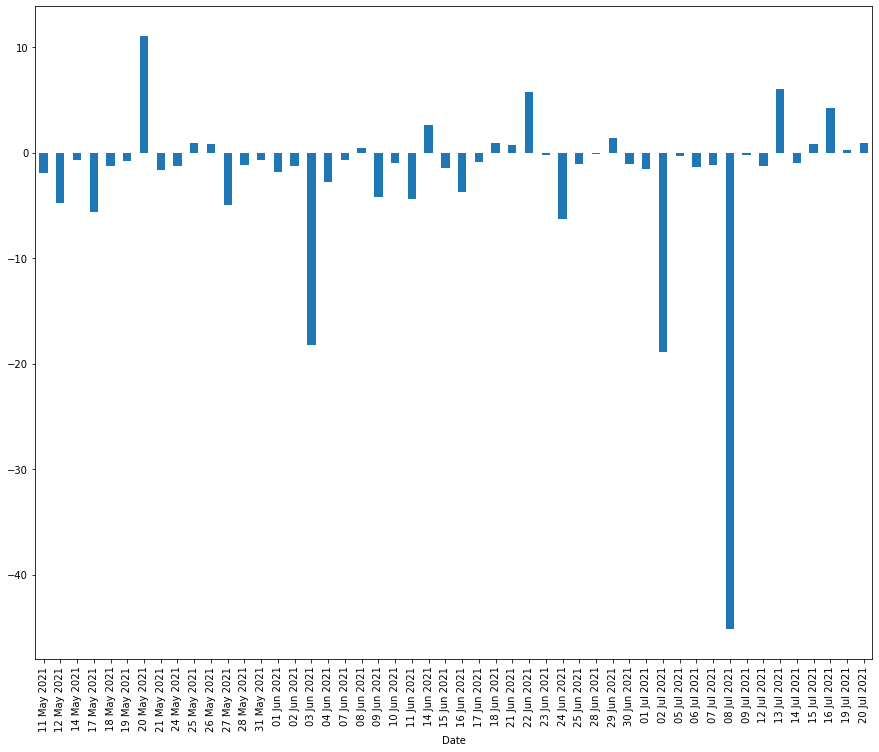

In [25]:
(fii_fig['FIIput'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

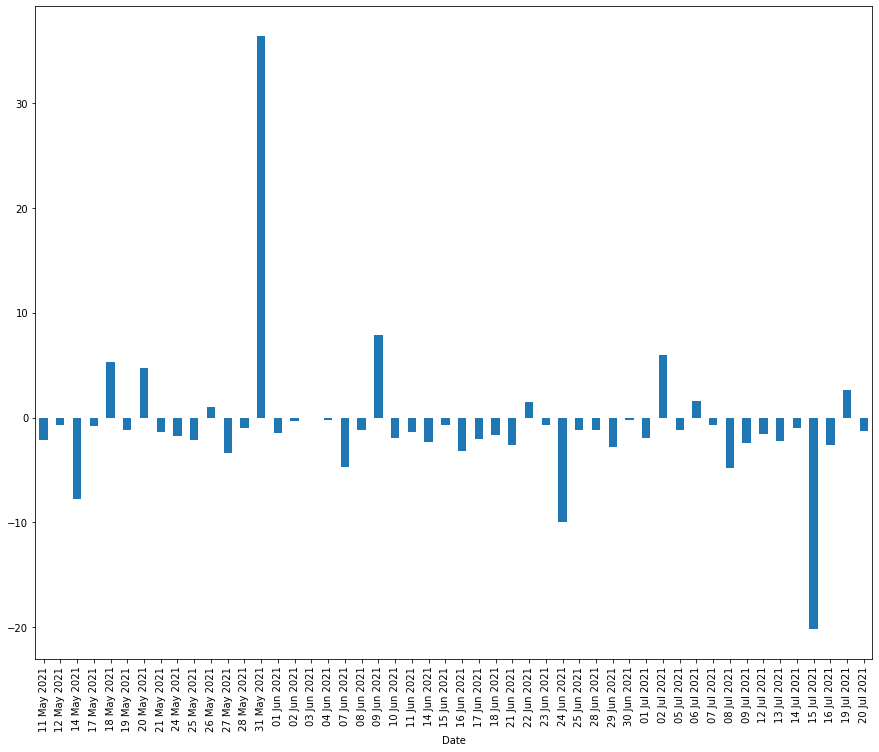

In [26]:
(fii_fig['FIIcall'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

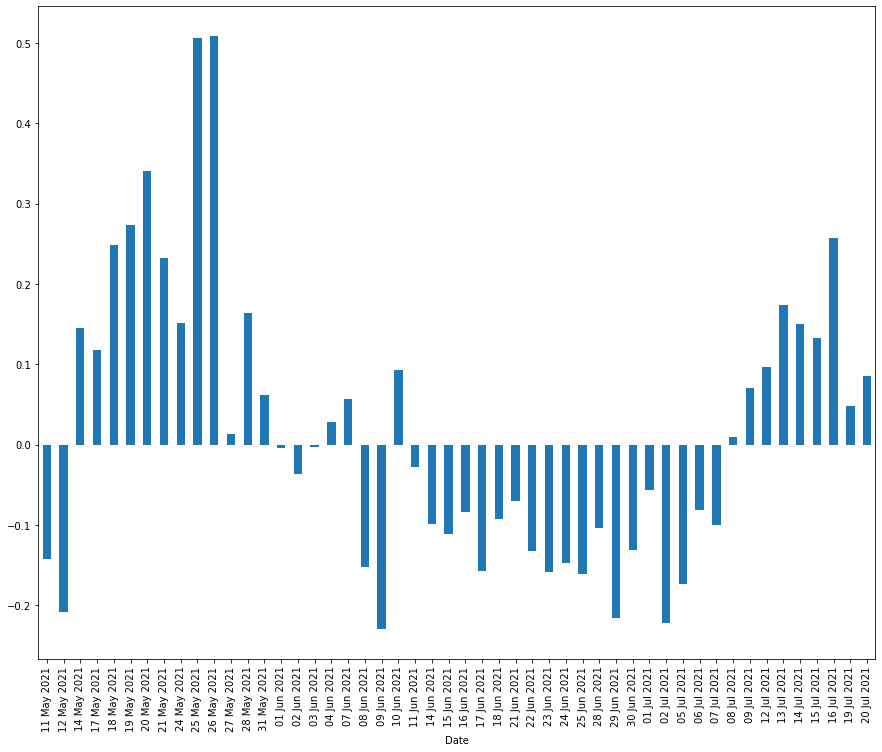

In [27]:
(fii_fig['FIIFutOI'].pct_change(10)[-50:]).plot(kind='bar',figsize=(15,12))


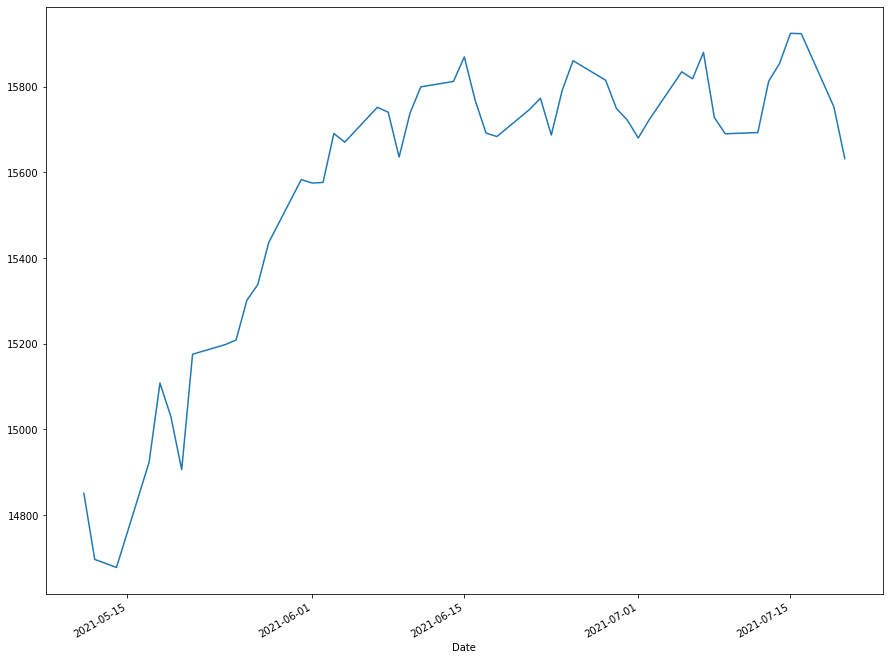

In [28]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [29]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [30]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 

In [31]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=35,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

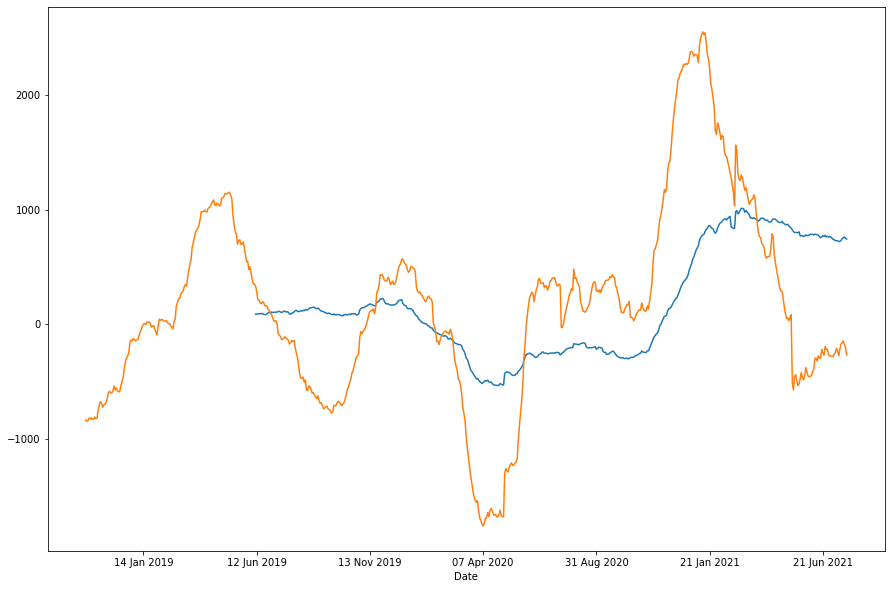

In [41]:
fii_fig.MA200.plot(figsize=(15,10))
fii_fig.MA50.plot()


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['MA200','MA50']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

In [33]:
import plotly.express as px
import plotly.graph_objects as go


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

In [ ]:
!pip install chart-studio

In [48]:
import plotly.io as pio
pio.renderers.default='notebook'

In [54]:
import chart_studio.plotly as py
import plotly.graph_objs as go
trace1=go.Scatter(x=[1,2],y=[2,1])
trace2=go.Scatter(x=[1,2],y=[2,1])
fig=go.Figure([trace1,trace2])

In [55]:
fig.show()

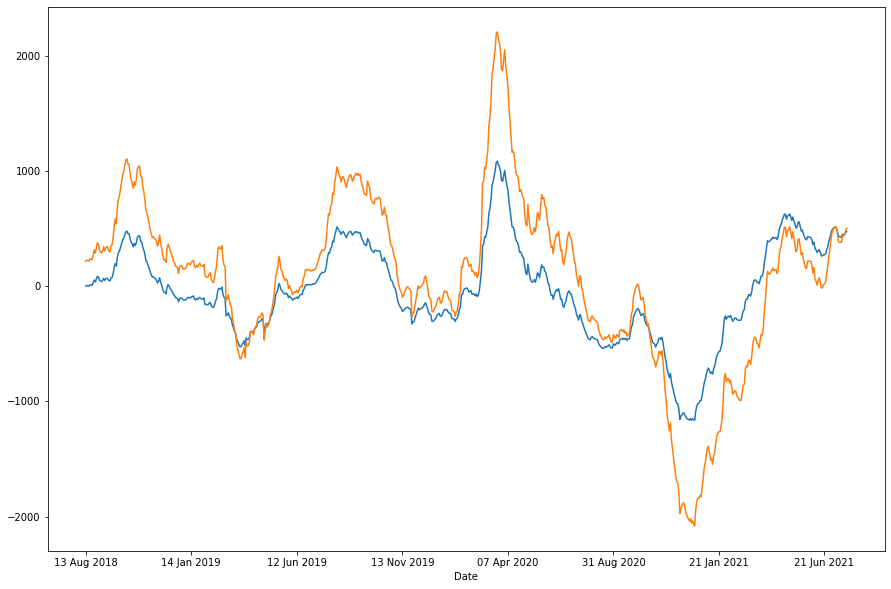

In [34]:
fii_fig.macd_dom.plot(figsize=(15,10),xlabel='macd')
fii_fig.signal_dom.plot()
plt.show()

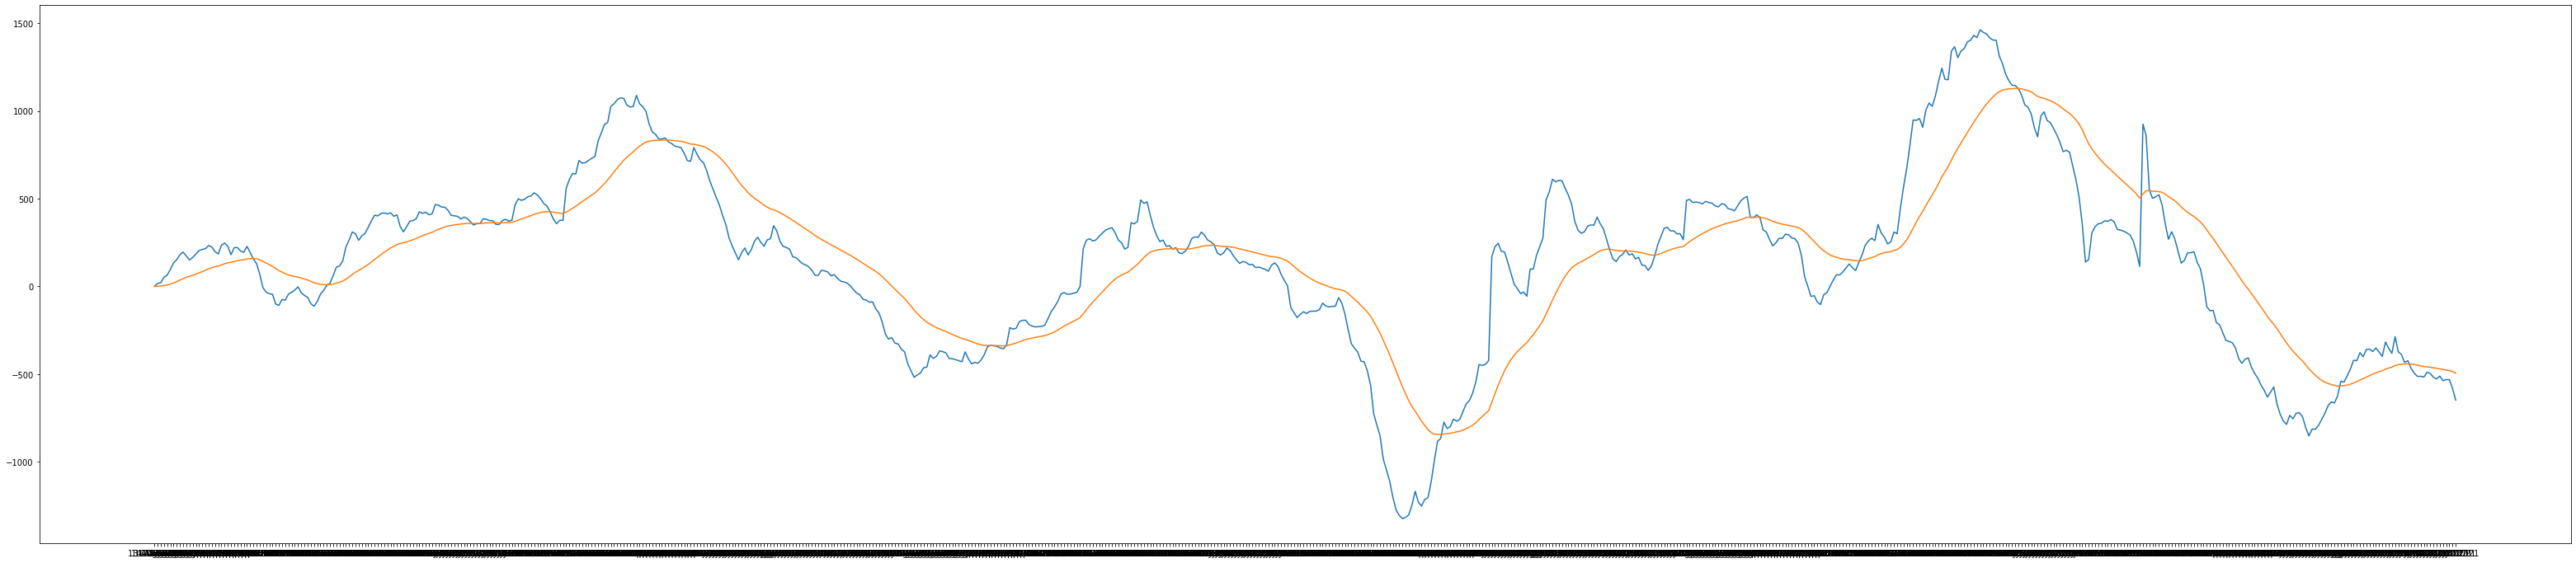

In [35]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()